### Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsforecast.models import SeasonalExponentialSmoothing, SeasonalNaive, Naive
from sklearn.linear_model import LinearRegression
from neuralforecast.models import NBEATS, MLP
from statsmodels.tsa.stattools import adfuller

### Read and check data

In [26]:
df_full = pd.read_csv('Month_Value_1.csv')

In [27]:
df_full.isna().sum()

Period                                       0
Revenue                                     32
Sales_quantity                              32
Average_cost                                32
The_average_annual_payroll_of_the_region    32
dtype: int64

### Data has null values for future, set them aside for prediction

In [28]:
df = df_full[df_full['Revenue'].isna() == False]

In [29]:
prediction_periods = df_full[df_full['Revenue'].isna() == True]

In [30]:
df.dtypes

Period                                       object
Revenue                                     float64
Sales_quantity                              float64
Average_cost                                float64
The_average_annual_payroll_of_the_region    float64
dtype: object

In [31]:
df.describe()

,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
count,6.400000e+01,64.000000,64.000000,6.400000e+01
mean,3.236045e+07,19197.375000,1695.061159,2.869083e+07
std,1.164150e+07,6591.287257,296.844793,1.057191e+06
min,1.402148e+07,8314.000000,1110.576805,2.740647e+07
25%,2.242655e+07,15065.500000,1499.142841,2.782857e+07
50%,3.209088e+07,18368.000000,1654.399798,2.819785e+07
75%,3.992999e+07,22856.250000,1916.401096,2.987852e+07
max,5.875647e+07,38069.000000,2559.328184,3.002468e+07


In [32]:
df['Source'] = 'History'
prediction_periods['Source'] = 'Forecast'

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_28831/4136773201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Source'] = 'History'
/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_28831/4136773201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_periods['Source'] = 'Forecast'


### Plot various fields

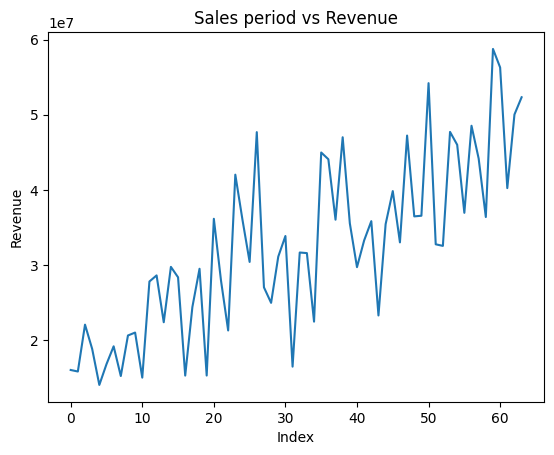

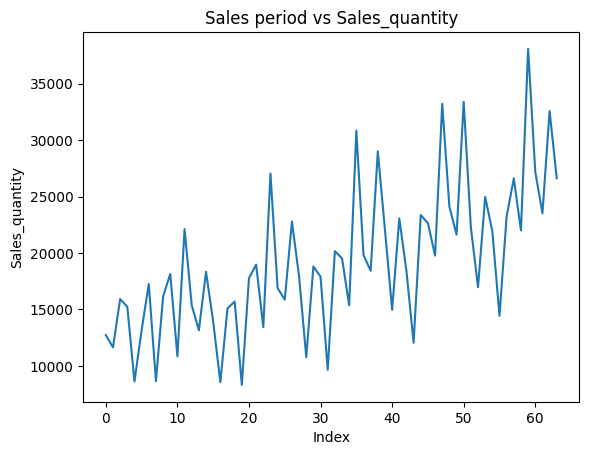

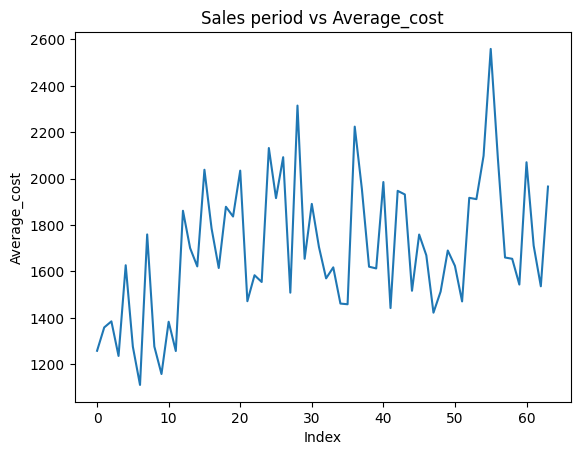

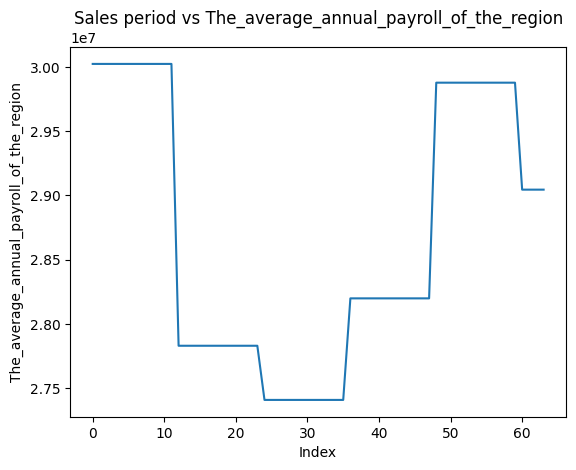

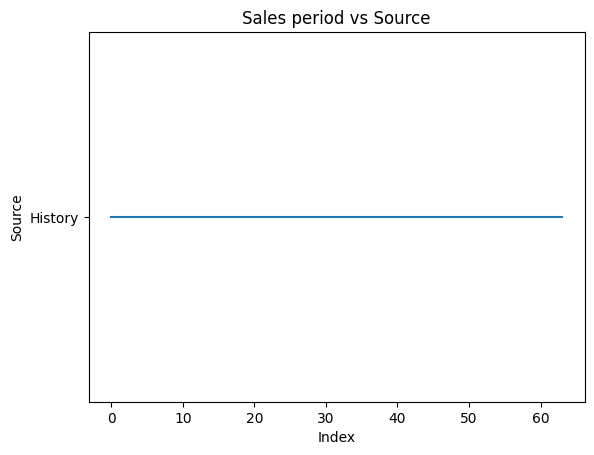

In [33]:
for i in df.columns[1:]:
    plt.plot(df['Period'], df[i])
    plt.xscale('linear')
    plt.title(f'Sales period vs {i}')
    plt.xlabel('Index')
    plt.ylabel(i)
    plt.show()

### Create horizon

In [34]:
horizon = prediction_periods.shape[0]

### Naive average function

In [35]:
# both train and predict in this function
def NaiveAverage(df, h, month_lag):
    # tts
    X_train, X_test, y_train, y_test = train_test_split(df['Period'], df['Sales_quantity'], test_size=.25, shuffle=False)
    
    # 'training'
    y_full = df['Sales_quantity'].values
    y_test_preds =[]
    
    for i in range(X_test.shape[0]):
        counter = y_train.shape[0]
        forecast = np.average(y_full[y_train.shape[0] - month_lag + i: y_train.shape[0] + i])
        y_test_preds.append(forecast)

    mae = mean_absolute_error(y_test, y_test_preds)
    mse = mean_squared_error(y_test, y_test_preds)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_test_preds)

    errors = (mae, mse, rmse, mape)

    y_preds = []
    y_full = [i for i in df['Sales_quantity'].values]

    for i in range(h):
        forecast = np.average(y_full[-month_lag:])
        y_preds.append(forecast)
        y_full.append(forecast)


    return y_preds, y_test_preds, errors, (X_train, X_test, y_train, y_test)


In [36]:
x = NaiveAverage(df, horizon, 3)

In [37]:
preds, test_preds, errors, test_sets = NaiveAverage(df, horizon, 3)

### Check results

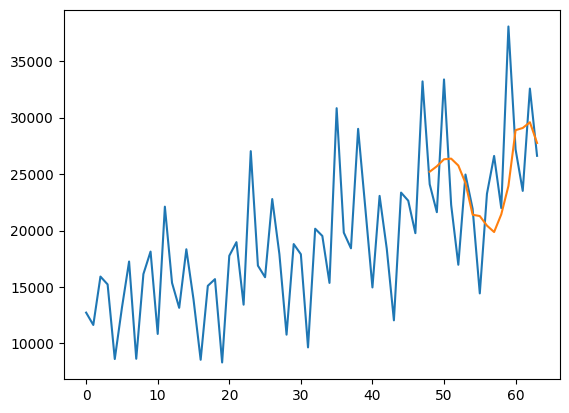

In [38]:
plt.plot(range(df['Period'].shape[0]), df['Sales_quantity'])
plt.plot(range(test_sets[0].shape[0], test_sets[0].shape[0] + test_sets[1].shape[0]), test_preds)

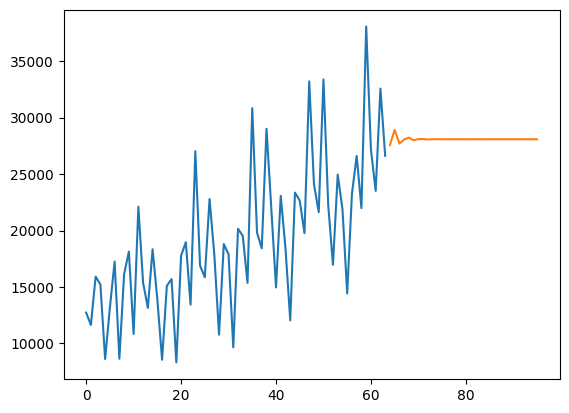

In [39]:
plt.plot(range(df['Period'].shape[0]), df['Sales_quantity'])
plt.plot(range(df.shape[0], df.shape[0] + horizon), preds)

### Check errors

In [40]:
print(f'MAE: {errors[0]}')
print(f'MSE: {errors[1]}')
print(f'RMSE: {errors[2]}')
print(f'MASE: {errors[3]}')

MAE: 4305.395833333333
MSE: 31670350.506944444
RMSE: 5627.641646990722
MASE: 0.18008205028975463
